In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [ ]:
%run params.py

In [2]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [3]:
analysis = scripts.Analysis()

In [4]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [ ]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [6]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [7]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [8]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [9]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [10]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1900

nband = 1100

nv = 200

dv = 0.005

tsfc =294

ng =9

nref =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

ng_refs = (/ 9 /) 

data wgt
     &     /1 , 1 , 1 , 1,
     &     1 , 1 , 1 , 1,
     &     1/

option_wgt_flux =2

option_wgt_k =1

option_klin =0

klin =0


In [11]:
fig.display_hrefanchor()

In [12]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [13]:
table_dgdgs.display_hrefanchor()

In [14]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [15]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [16]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

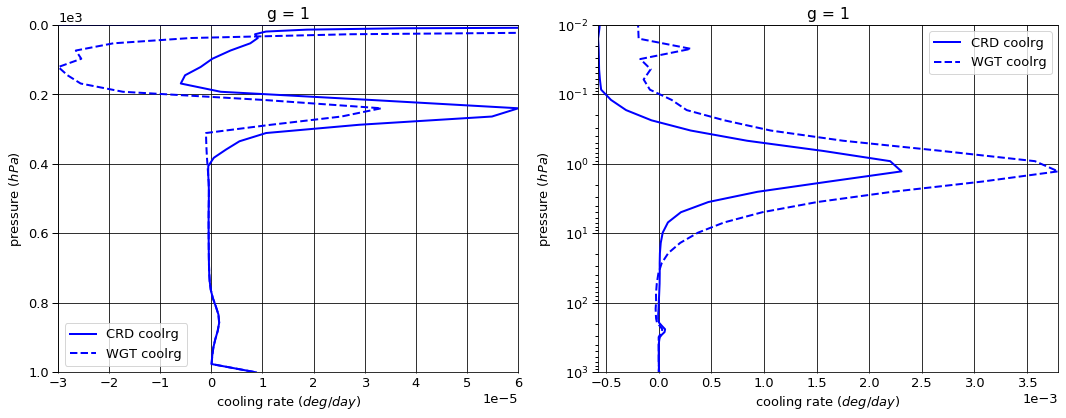

# Figure: cooling rate g-group 2

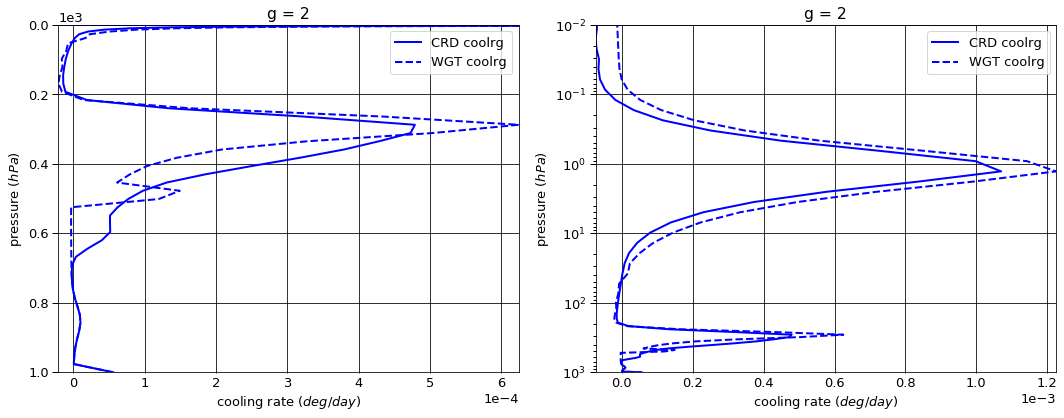

# Figure: cooling rate g-group 3

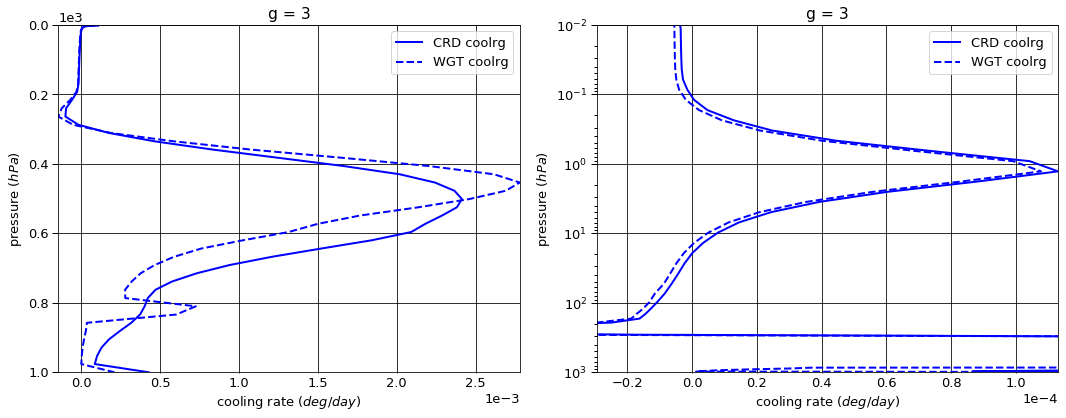

# Figure: cooling rate g-group 4

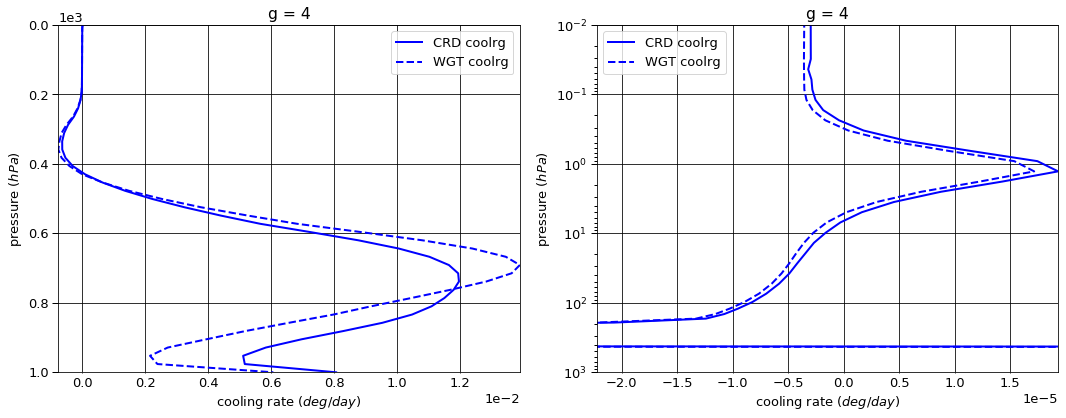

# Figure: cooling rate g-group 5

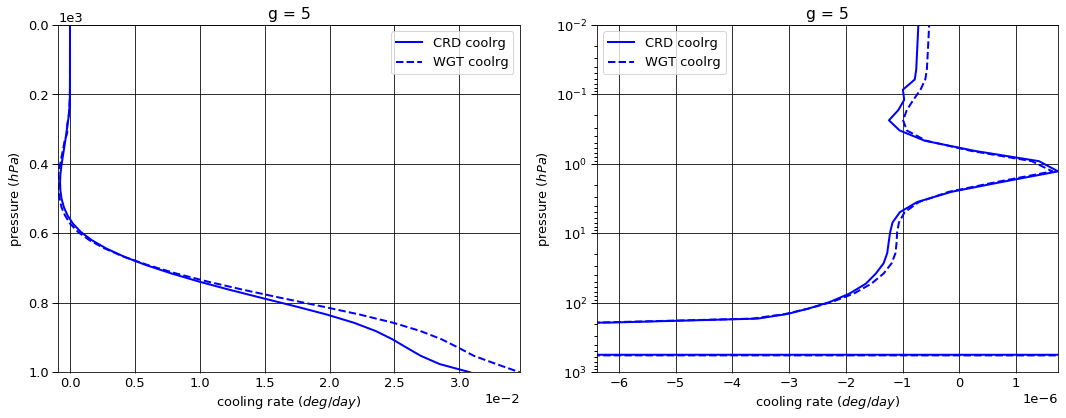

# Figure: cooling rate g-group 6

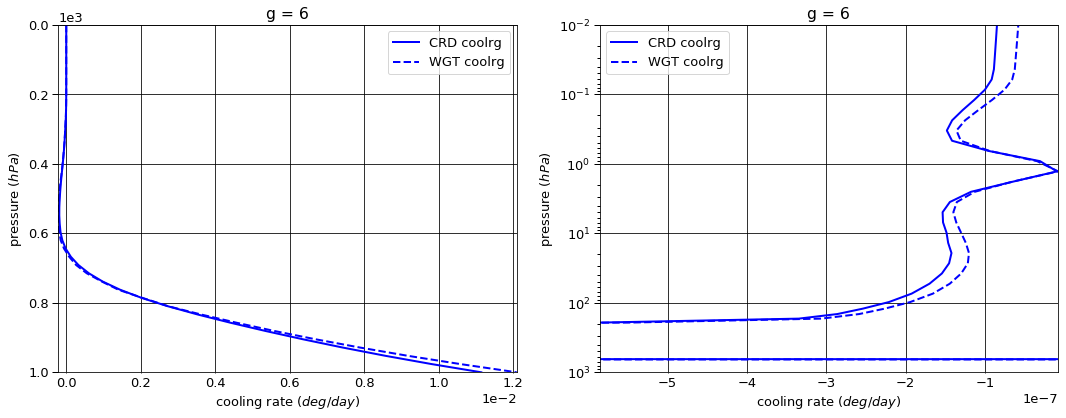

# Figure: cooling rate g-group 7

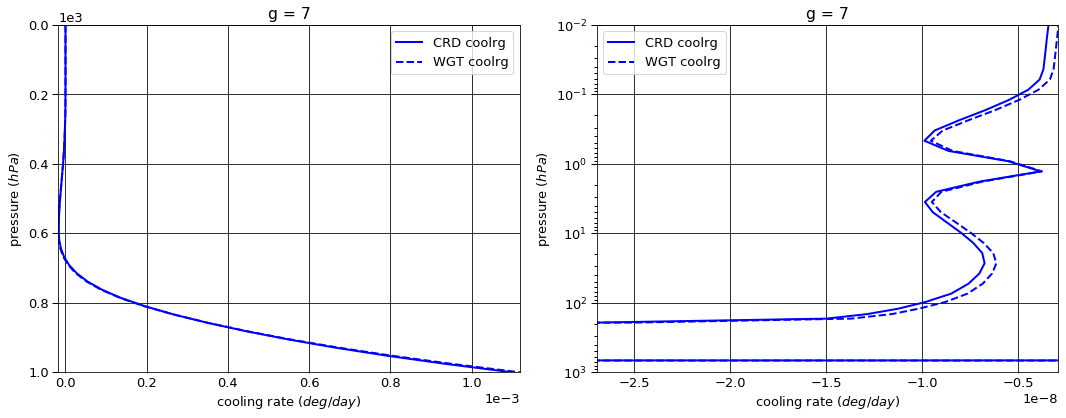

# Figure: cooling rate g-group 8

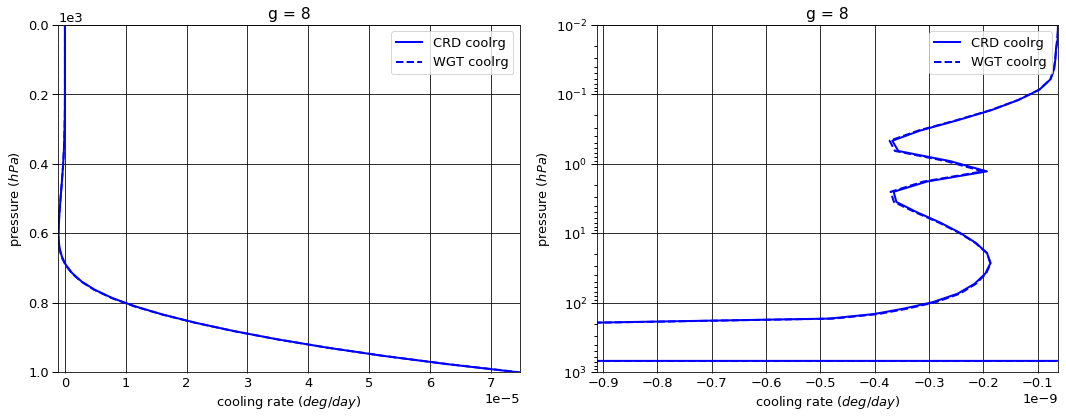

# Figure: cooling rate g-group 9

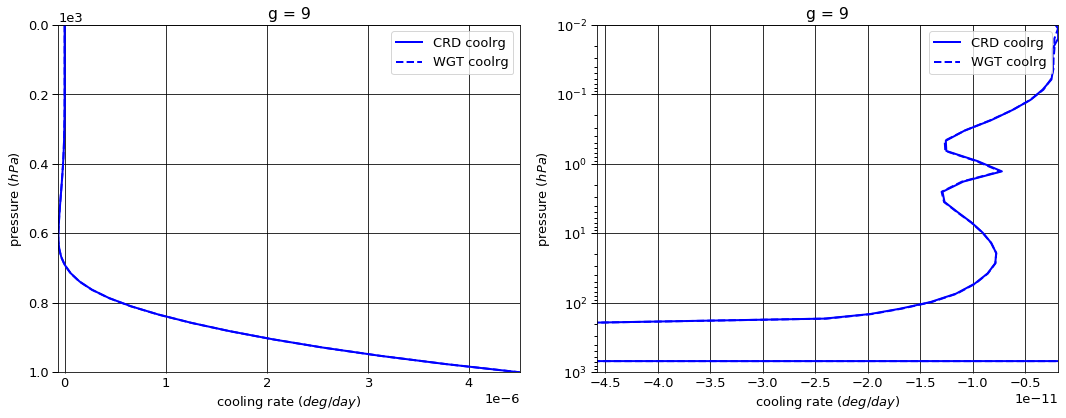

# Figure: cooling rate g-group total

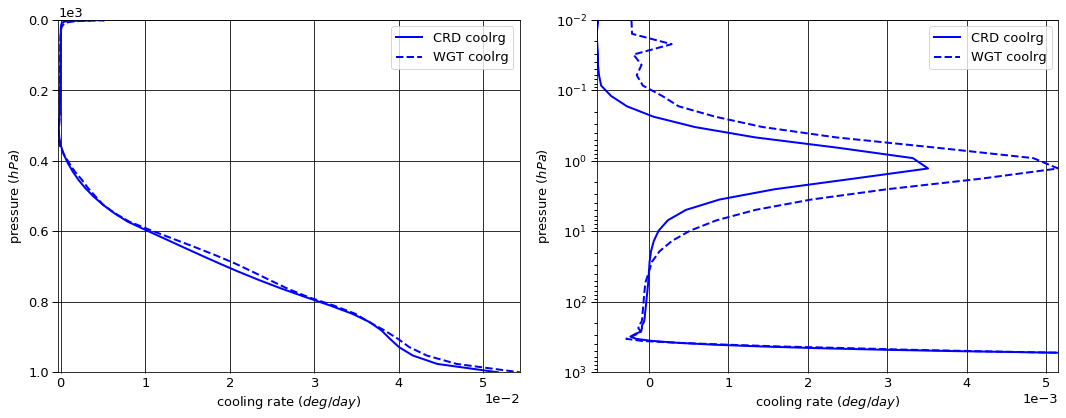

In [17]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [18]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001235  0.000000 -0.001235
  1013.0   76    -0.017263  0.017238 -0.000025
2 0.0      1     -0.010720  0.000000 -0.010720
  1013.0   76    -0.109222  0.109065 -0.000157
3 0.0      1     -0.091217  0.000000 -0.091217
  1013.0   76    -0.413675  0.412566 -0.001109
4 0.0      1     -0.546838  0.000000 -0.546838
  1013.0   76    -1.166410  1.127719 -0.038691
5 0.0      1     -1.403209  0.000000 -1.403209
  1013.0   76    -1.804924  1.172757 -0.632167
6 0.0      1     -1.438342  0.000000 -1.438342
  1013.0   76    -1.503024  0.242375 -1.260649
7 0.0      1     -0.863795  0.000000 -0.863795
  1013.0   76    -0.868822  0.020401 -0.848421
8 0.0      1     -0.469764  0.000000 -0.469764
  1013.0   76    -0.470074  0.001302 -0.468773
9 0.0      1     -0.272021  0.000000 -0.272021
  1013.0   76    -0.272039  0.000077 -0.271962


WGT


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001609  0.000000 -0.001609
  1013.0   76    -0.017263  0.017238 -0.000025
2 0.0      1     -0.008991  0.000000 -0.008991
  1013.0   76    -0.109222  0.109065 -0.000157
3 0.0      1     -0.080079  0.000000 -0.080079
  1013.0   76    -0.413675  0.413078 -0.000597
4 0.0      1     -0.499598  0.000000 -0.499598
  1013.0   76    -1.166410  1.146739 -0.019670
5 0.0      1     -1.363051  0.000000 -1.363051
  1013.0   76    -1.804924  1.305434 -0.499490
6 0.0      1     -1.434288  0.000000 -1.434288
  1013.0   76    -1.503024  0.255370 -1.247654
7 0.0      1     -0.863665  0.000000 -0.863665
  1013.0   76    -0.868822  0.020645 -0.848177
8 0.0      1     -0.469759  0.000000 -0.469759
  1013.0   76    -0.470074  0.001304 -0.468770
9 0.0      1     -0.272020  0.000000 -0.272020
  1013.0   76    -0.272039  0.000077 -0.271962


WGT - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1     -3.741516e-04  0.000000e+00 -3.741516e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2 0.0      1      1.729178e-03  0.000000e+00  1.729178e-03
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
3 0.0      1      1.113802e-02  0.000000e+00  1.113802e-02
  1013.0   76     0.000000e+00  5.118900e-04  5.118945e-04
4 0.0      1      4.723981e-02  0.000000e+00  4.723981e-02
  1013.0   76     0.000000e+00  1.902040e-02  1.902035e-02
5 0.0      1      4.015810e-02  0.000000e+00  4.015810e-02
  1013.0   76     0.000000e+00  1.326769e-01  1.326770e-01
6 0.0      1      4.054200e-03  0.000000e+00  4.054200e-03
  1013.0   76     0.000000e+00  1.299474e-02  1.299480e-02
7 0.0      1      1.296700e-04  0.000000e+00  1.296700e-04
  1013.0   76     0.000000e+00  2.439020e-04  2.439000e-04
8 0.0      1      4.800000e-06  0.000000e+00  4.800000e-06
  1013.0   76     0.000000e+00  2.616900e-06  2.620000e-06
9 0.0      1      9.000000e-08  0.000000e+00  9.000000e-08
  1013.0   76     0.000000e+00  1.234400e-08  1.000000e-08

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -5.962096e-04
  1001.112500 75     8.732450e-06
2 0.000312    1     -7.402801e-05
  1001.112500 75     5.562999e-05
3 0.000312    1     -3.935561e-06
  1001.112500 75     4.286707e-04
4 0.000312    1     -2.963017e-06
  1001.112500 75     8.065373e-03
5 0.000312    1     -6.567048e-07
  1001.112500 75     3.082830e-02
6 0.000312    1     -7.829315e-08
  1001.112500 75     1.114921e-02
7 0.000312    1     -2.996034e-09
  1001.112500 75     1.100105e-03
8 0.000312    1     -5.103465e-11
  1001.112500 75     7.456209e-05
9 0.000312    1     -1.501019e-12
  1001.112500 75     4.503435e-06


WGT


coolrg
g pressure    layer              
1 0.000312    1     -2.226500e-04
  1001.112500 75     8.732450e-06
2 0.000312    1     -2.055063e-05
  1001.112500 75     5.562999e-05
3 0.000312    1     -5.722990e-06
  1001.112500 75     2.120195e-04
4 0.000312    1     -3.476061e-06
  1001.112500 75     6.069999e-03
5 0.000312    1     -4.618845e-07
  1001.112500 75     3.465628e-02
6 0.000312    1     -5.058734e-08
  1001.112500 75     1.210091e-02
7 0.000312    1     -2.496195e-09
  1001.112500 75     1.118765e-03
8 0.000312    1     -4.728210e-11
  1001.112500 75     7.480965e-05
9 0.000312    1     -1.501019e-12
  1001.112500 75     4.504356e-06


WGT - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.735596e-04
  1001.112500 75     0.000000e+00
2 0.000312    1      5.347738e-05
  1001.112500 75     0.000000e+00
3 0.000312    1     -1.787429e-06
  1001.112500 75    -2.166512e-04
4 0.000312    1     -5.130438e-07
  1001.112500 75    -1.995374e-03
5 0.000312    1      1.948202e-07
  1001.112500 75     3.827978e-03
6 0.000312    1      2.770581e-08
  1001.112500 75     9.516970e-04
7 0.000312    1      4.998393e-10
  1001.112500 75     1.865980e-05
8 0.000312    1      3.752548e-12
  1001.112500 75     2.475550e-07
9 0.000312    1      0.000000e+00
  1001.112500 75     9.218000e-10

# Table: flux. g-groups total


CRD


flug    fldg     fnetg
pressure level                            
0.0      1     -5.097139  0.0000 -5.097139
1013.0   76    -6.625452  3.1035 -3.521952


WGT


flug      fldg     fnetg
pressure level                              
0.0      1     -4.993060  0.000000 -4.993060
1013.0   76    -6.625452  3.268951 -3.356502


WGT - CRD


flug     fldg     fnetg
pressure level                            
0.0      1      0.10408  0.00000  0.104080
1013.0   76     0.00000  0.16545  0.165451

# Table: cooling rate. g-groups total


CRD


coolrg
pressure    layer          
0.000312    1     -0.000678
1001.112500 75     0.051715


WGT


coolrg
pressure    layer          
0.000312    1     -0.000253
1001.112500 75     0.054302


WGT - CRD


coolrg
pressure    layer          
0.000312    1      0.000425
1001.112500 75     0.002587

In [19]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

dg       dgs
g                    
1  0.000755  0.003099
2  0.005055  0.019377
3  0.022155  0.072670
4  0.078445  0.201866
5  0.206973  0.291172
6  0.324718  0.210726
7  0.187273  0.112199
8  0.108759  0.056738
9  0.065868  0.032152

In [20]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

abscom
g              
1  2.361442e-20
2  2.054785e-21
3  1.787950e-22
4  1.555766e-23
5  1.353734e-24
6  1.177938e-25
7  1.024970e-26
8  8.918675e-28
9  7.760493e-29

In [1]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [22]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

abscom  k(ig) / k(ig - 1)        dg       dgs  dg cumsum  dgs cumsum  \
g                                                                               
1  2.361442e-20                NaN  0.000755  0.003099   0.000755    0.003099   
2  2.054785e-21           0.087014  0.005055  0.019377   0.005809    0.022476   
3  1.787950e-22           0.087014  0.022155  0.072670   0.027964    0.095147   
4  1.555766e-23           0.087014  0.078445  0.201866   0.106409    0.297012   
5  1.353734e-24           0.087014  0.206973  0.291172   0.313382    0.588184   
6  1.177938e-25           0.087014  0.324718  0.210726   0.638100    0.798911   
7  1.024970e-26           0.087014  0.187273  0.112199   0.825373    0.911110   
8  8.918675e-28           0.087014  0.108759  0.056738   0.934132    0.967848   
9  7.760493e-29           0.087014  0.065868  0.032152   1.000000    1.000000   

    pref  
g         
1  600.0  
2  600.0  
3  600.0  
4  600.0  
5  600.0  
6  600.0  
7  600.0  
8  600.0  
9  600.0

In [23]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [24]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     6.553670e-20  3.036000e-21  21.586529  5.581180e-06
      2 0.000312     2.477336e-21  9.092919e-23  27.244672  2.109728e-07
      3 0.000312     4.812239e-23  2.759966e-24  17.435860  4.098158e-09
      4 0.000312     3.917984e-24  2.269061e-25  17.266986  3.336600e-10
      5 0.000312     1.748359e-25  2.327806e-26   7.510756  1.488922e-11
      6 0.000312     1.662523e-26  2.019832e-27   8.230998  1.415824e-12
      7 0.000312     1.300668e-27  1.845331e-28   7.048429  1.107664e-13
      8 0.000312     4.625633e-29  1.236935e-29   3.739592  3.939242e-15
      9 0.000312     2.665551e-30  7.269209e-31   3.666906  2.270014e-16
2     1 0.000750     6.572060e-20  3.039146e-21  21.624693  2.254333e-06
      2 0.000750     2.486053e-21  9.109339e-23  27.291254  8.527603e-08
      3 0.000750     4.830228e-23  2.767481e-24  17.453515  1.656854e-09
      4 0.000750     3.931994e-24  2.276857e-25  17.269397  1.348744e-10
      5 0.000750     1.763445e-25  2.339299e-26   7.538347  6.048928e-12
      6 0.000750     1.675844e-26  2.031145e-27   8.250738  5.748443e-13
      7 0.000750     1.312091e-27  1.856924e-28   7.065936  4.500704e-14
      8 0.000750     4.688179e-29  1.247138e-29   3.759149  1.608129e-15
      9 0.000750     2.701488e-30  7.332421e-31   3.684306  9.266585e-17
3     1 0.001052     6.611135e-20  3.045443e-21  21.708290  3.180242e-06
      2 0.001052     2.504625e-21  9.142064e-23  27.396716  1.204833e-07
      3 0.001052     4.868689e-23  2.782706e-24  17.496242  2.342050e-09
      4 0.001052     3.961880e-24  2.292851e-25  17.279273  1.905835e-10
      5 0.001052     1.795886e-25  2.363264e-26   7.599176  8.638986e-12
      6 0.001052     1.704499e-26  2.054915e-27   8.294743  8.199376e-13
      7 0.001052     1.336719e-27  1.881449e-28   7.104734  6.430197e-14
      8 0.001052     4.823637e-29  1.268882e-29   3.801485  2.320378e-15
      9 0.001052     2.779260e-30  7.466929e-31   3.722093  1.336944e-16
4     1 0.001476     6.652578e-20  3.052193e-21  21.796057  4.489503e-06
      2 0.001476     2.524406e-21  9.177164e-23  27.507477  1.703600e-07
      3 0.001476     4.909896e-23  2.799022e-24  17.541471  3.313451e-09
      4 0.001476     3.993811e-24  2.310027e-25  17.289025  2.695230e-10
      5 0.001476     1.830927e-25  2.388865e-26   7.664420  1.235604e-11
      6 0.001476     1.735448e-26  2.080315e-27   8.342238  1.171170e-12
      7 0.001476     1.363399e-27  1.907692e-28   7.146852  9.200921e-14
      8 0.001476     4.971324e-29  1.292263e-29   3.846989  3.354906e-15
      9 0.001476     2.864023e-30  7.611798e-31   3.762610  1.932790e-16
5     1 0.002070     6.694136e-20  3.059078e-21  21.882853  6.336254e-06
      2 0.002070     2.544329e-21  9.212991e-23  27.616756  2.408305e-07
      3 0.002070     4.951656e-23  2.815653e-24  17.586176  4.686931e-09
      4 0.002070     4.026084e-24  2.327538e-25  17.297603  3.810841e-10
      5 0.002070     1.866737e-25  2.414786e-26   7.730443  1.766937e-11
      6 0.002070     1.767075e-26  2.106023e-27   8.390578  1.672604e-12
      7 0.002070     1.390747e-27  1.934277e-28   7.190010  1.316395e-13
      8 0.002070     5.123703e-29  1.316059e-29   3.893218  4.849780e-15
      9 0.002070     2.951450e-30  7.759510e-31   3.803655  2.793660e-16
6     1 0.002904     6.735771e-20  3.066140e-21  21.968244  8.943383e-06
      2 0.002904     2.564378e-21  9.249768e-23  27.723698  3.404839e-07
      3 0.002904     4.993943e-23  2.832680e-24  17.629747  6.630682e-09
      4 0.002904     4.058676e-24  2.345447e-25  17.304487  5.388885e-10
      5 0.002904     1.903303e-25  2.441067e-26   7.797012  2.527100e-11
      6 0.002904     1.799368e-26  2.132063e-27   8.439563  2.389102e-12
      7 0.002904     1.418758e-27  1.961215e-28   7.234074  1.883748e-13
      8 0.002904     5.280790e-29  1.340269e-29   3.940098  7.011541e-15
      9 0.0

# Histogram of wavenumbers in g-group 1

In [25]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [26]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
